In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from constants import ALL_COLS, LABEL
from ETL_class import DataTransformer

In [43]:
# model = torch.nn.Sequential(
#     torch.nn.Linear(len(ALL_COLS), 128), 
#     torch.nn.GELU(),
    
#     torch.nn.Linear(128, 64),
#     torch.nn.GELU(),
    
#     torch.nn.Linear(64, 2)   
# )

In [11]:
class model(torch.nn.Module):
    
    def __init__(self, all_cols):
        super().__init__()
        self.all_cols = all_cols
        self.lin_1 = torch.nn.Linear(len(self.all_cols), 32)
        self.gelu = torch.nn.GELU()
        self.lin_2 = torch.nn.Linear(32, 2)
        self.m = torch.nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.lin_1(x)
        x = self.gelu(x)
        x = self.lin_2(x)
        out = self.m(x)
        return out

    def fit(self):
        pass

# Train

In [44]:
def select_batch(X, y, label_col, batch_size=60):
    """
    Function that samples equal number of samples of each label from passed df 
    and returns X and y for train
    """
    pos_df = X[y==1].sample(int(batch_size/2))
    neg_df = X[y==0].sample(int(batch_size/2))
    df = pd.concat([pos_df, neg_df])#.reset_index(drop=True) 
    y = y[df.index].values
    return torch.tensor(df[ALL_COLS].values, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

def train_epoch(X, y, model, optimiser, steps=8):
    """Function that iterates through data and trains the model for 1 epoch"""
    m = torch.nn.LogSoftmax(dim=1)
    nll_loss = torch.nn.NLLLoss()

    for _ in range(steps):
        x_batch, y_batch = select_batch(X, y, LABEL)
        loss = nll_loss(m(model(x_batch)), y_batch)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    
    return model, optimiser, loss

In [13]:
# optimiser = torch.optim.Adam(model.parameters(), lr=0.00001)
raw_df = pd.read_csv('data_raw/train.csv')
# data_trans = DataTransformer(all_cols=ALL_COLS)
# raw_df = data_trans.fit_transform(raw_df)
X = raw_df[ALL_COLS]; y = raw_df[LABEL]

In [46]:
total_eval_loss = []; total_train_loss = []

for epoch in range(500):
    X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, stratify=y)
    model, optimiser, train_loss = train_epoch(X_train, y_train, model, optimiser)

    # testing on eval
    m = torch.nn.LogSoftmax(dim=1)
    nll_loss = torch.nn.NLLLoss()
    eval_x_tens = torch.tensor(X_eval.values, dtype=torch.float32)
    eval_y_tens = torch.tensor(y_eval.values, dtype=torch.long)
    eval_loss = nll_loss(m(model(eval_x_tens)), eval_y_tens)

    # saving losses
    total_eval_loss.append(eval_loss.detach().numpy())
    total_train_loss.append(train_loss.detach().numpy())
    if epoch%50==0:
        print(eval_loss)

tensor(7.2232, grad_fn=<NllLossBackward0>)
tensor(0.8504, grad_fn=<NllLossBackward0>)
tensor(0.7501, grad_fn=<NllLossBackward0>)
tensor(0.7114, grad_fn=<NllLossBackward0>)
tensor(0.6628, grad_fn=<NllLossBackward0>)
tensor(0.6248, grad_fn=<NllLossBackward0>)
tensor(0.6796, grad_fn=<NllLossBackward0>)
tensor(0.6724, grad_fn=<NllLossBackward0>)
tensor(0.6304, grad_fn=<NllLossBackward0>)
tensor(0.6479, grad_fn=<NllLossBackward0>)


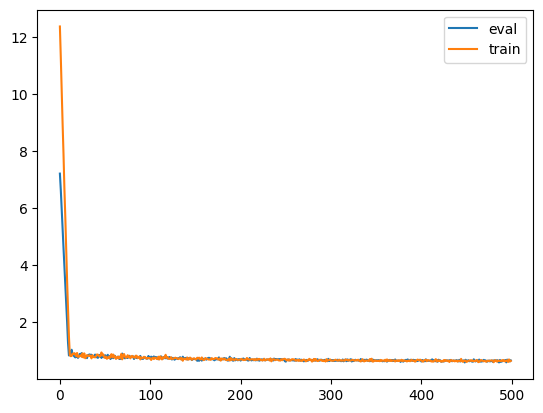

In [47]:
plt.plot(total_eval_loss, label='eval')
plt.plot(total_train_loss, label='train')
plt.legend()


# Test

In [364]:
test_df = pd.read_csv('data_raw/test.csv')
raw_test = torch.tensor(test_df[ALL_COLS].values, dtype=torch.float32)
submit_df = test_df[['Id']].copy()

In [365]:
submit_df.loc[:, 'y'] = model(raw_test).argmax(dim=1).reshape(-1,1).detach().numpy()

In [366]:
submit_df.to_csv('data_submissions/2nd_submit.csv', index=False)